# ATMS 597 Project 5 Group F Notebook
-----
Max Grover, Xinchang Li, Piyush Garg

Site: KMKG (Muskegon, MI)

Tasks: Use supervised classification techniques to predict frozen vs. liquid precipitation type (i.e., when it is not raining, so rain and freezing rain vs. other categories such as snow, sleet, etc.) at the surface in ASOS weather observations.

Model 1: Logistic Regression classification with default values (baseline)

Model 2: Your pick!

Data: You will use 5-minute Automated Surface Observation System data available from NCDC (ftp://ftp.ncdc.noaa.gov/pub/data/asos-fivemin/). Data from 2000-2020 is available. Use a 70-30 random split to perform training and validation.

You can use Temperature, Dewpoint, Wind Direction, Wind Speed, and other derived variables from those data, or synthetic variables such as solar zenith angle, time of day, etc.

The group with the improvement of values of Briar Skill Score for their Model 2 over the baseline SVM model will be given a prize.

Course presentations will be Thursday, April 23. A colab notebook or jupyter notebook can be submitted for the assignment.

Good luck!

# Install and import modules

In [0]:
# Import neccessary libraries
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
!pip install metpy==1.0.0rc1
from datetime import datetime
import pandas as pd
from IPython.display import clear_output
from metpy.io import parse_metar_to_dataframe
import metpy.calc as mcalc
from metpy.units import units
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

%pylab inline
import seaborn as sns; sns.set()

Selecting previously unselected package python-pkg-resources.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../0-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../1-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../2-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../4-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../5-pyth

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Retrieve data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set your data directory
YOUR_DIR = '/content/drive/My Drive/Colab Notebooks/ATMS 597/P05/data' #Cathy
# YOUR_DIR = '' #Max
# YOUR_DIR = ... #Piyush
%cd $YOUR_DIR

/content/drive/My Drive/Colab Notebooks/ATMS 597/P05/data


In [0]:
# # UNCOMMENT TO RETREIVE DATA FILES # #

# # Create a date range for dynamically generating file names
# date_range = pd.date_range(start = '2000-01', end = '2020-03', freq = 'MS')
# path_base = 'ftp://ftp.ncdc.noaa.gov/pub/data/asos-fivemin/6401-'

# # Loop through all files and save to the set directory
# for date in date_range:
#     # Set up output clearing to save screen space
#     clear_output(wait = True)
#     print('working on ' + str(date.year))
#     # Set file URL
#     PATH = path_base + str(date.year) + '/64010KMKG' + date.strftime('%Y%m') + '.dat'
#     # Get the file with silent output
#     !wget -q $PATH

working on 2020


# Clean up data

In [0]:
!pwd

/content/drive/My Drive/Colab Notebooks/ATMS 597/P05/data


In [0]:
# Define a data parser function:

def parse_metar_file(file, wx_subset=True):
    """
    Parses METAR file from NCDC
    Input:
    --------
    file = Text file downloaded from NCDC
    wx_subset = Flag to determine whether or not to drop non-current weather obs (if True, only returns obs with observed weather)
    Output:
    --------
    df = Pandas dataframe filtered for times where current weather is not 'nan'
    """

    # Read in the file using Pandas
    df = pd.read_csv(file, header=None)

    # Pull the timestamp from the filename
    timestamp = datetime.strptime(file[-10:], '%Y%m.dat')

    # Iterrate over rows to parse METARS
    df_list = []
    for index, row in df.iterrows():
        try:
            df_list.append(parse_metar_to_dataframe(row.values[0][52:], year=timestamp.year, month=timestamp.month))
        except:
            print('Error with METAR: ', row.values[0][52:])
    #
    merged_df = pd.concat(df_list)

    # Drop datasets that do not include current weather
    merged_df = merged_df.dropna(subset=['current_wx1'])

    # Change the index to datetime
    merged_df.index = merged_df.date_time

    # Return the merged dataset sorted by datetime
    return merged_df.sort_index()


In [0]:
# # UNCOMMENT TO PARSE THE DATA # #

# # Find all files in the data directory
# files = sorted(glob.glob('data/*.dat'))

# # Create a list to store the dataframes in
# merged_datasets = []

# # Loop through and parse the different datasets
# for file in files:
#     print(file[-10:])
#     try:
#         merged_datasets.append(parse_metar_file(file))
#     except:
#         print("Error with :", file)

# # Return the cleaned dataset
# clean_df = pd.concat(merged_datasets)

# # Save the file to memory
# clean_df.to_csv('clean_dataset.csv')
# # Print out the resulting dataset
# print(clean_df)

In [0]:
# # UNCOMMENT TO READ IN THE SAVED FILE FROM DRIVE # #

# clean_df = pd.read_csv(YOUR_DIR + '/clean_dataset.csv', 
#                        index_col=0, parse_dates=True, 
#                        infer_datetime_format=True)
# clean_df


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station_id,latitude,longitude,elevation,date_time.1,wind_direction,wind_speed,current_wx1,current_wx2,current_wx3,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,past_weather2,air_pressure_at_sea_level,eastward_wind,northward_wind
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,KMKG,43.17,-86.23,191,2000-01-01 00:00:00,270.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,7.000000,1.285879e-15
2000-01-01 00:05:00,KMKG,43.17,-86.23,191,2000-01-01 00:05:00,280.0,10.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,9.848078,-1.736482e+00
2000-01-01 00:10:00,KMKG,43.17,-86.23,191,2000-01-01 00:10:00,280.0,11.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,10.832885,-1.910130e+00
2000-01-01 00:15:00,KMKG,43.17,-86.23,191,2000-01-01 00:15:00,290.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,6.577848,-2.394141e+00
2000-01-01 00:20:00,KMKG,43.17,-86.23,191,2000-01-01 00:20:00,280.0,9.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,8.863270,-1.562834e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 18:25:00,KMKG,43.17,-86.23,191,2020-03-30 18:25:00,330.0,12.0,-RA,NaN,NaN,SCT,1700.0,OVC,2300.0,NaN,NaN,NaN,NaN,8,5.0,0.0,30.08,61,0,0,NaN,6.000000,-1.039230e+01
2020-03-30 18:30:00,KMKG,43.17,-86.23,191,2020-03-30 18:30:00,320.0,13.0,-RA,NaN,NaN,SCT,1700.0,BKN,2300.0,OVC,2900.0,NaN,NaN,8,4.0,1.0,30.08,61,0,0,NaN,8.356239,-9.958578e+00
2020-03-30 18:35:00,KMKG,43.17,-86.23,191,2020-03-30 18:35:00,340.0,12.0,-RA,NaN,NaN,FEW,1700.0,BKN,2400.0,OVC,3000.0,NaN,NaN,8,6.0,1.0,30.09,61,0,0,NaN,4.104242,-1.127631e+01


In [0]:
# Or read in the file from github repo
!wget https://raw.githubusercontent.com/cathyxinchangli/ATMS-597-Project-5-Group-F/master/clean_dataset.csv

clean_df = pd.read_csv('clean_dataset.csv', 
                       index_col=0, parse_dates=True, 
                       infer_datetime_format=True)
clean_df

--2020-04-23 00:51:36--  https://raw.githubusercontent.com/cathyxinchangli/ATMS-597-Project-5-Group-F/master/clean_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69819771 (67M) [text/plain]
Saving to: ‘clean_dataset.csv’

clean_dataset.csv   100%[===================>]  66.58M  74.4MB/s    in 0.9s    

2020-04-23 00:51:38 (74.4 MB/s) - ‘clean_dataset.csv’ saved [69819771/69819771]



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station_id,latitude,longitude,elevation,date_time.1,wind_direction,wind_speed,current_wx1,current_wx2,current_wx3,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,past_weather2,air_pressure_at_sea_level,eastward_wind,northward_wind
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,KMKG,43.17,-86.23,191,2000-01-01 00:00:00,270.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,7.000000,1.285879e-15
2000-01-01 00:05:00,KMKG,43.17,-86.23,191,2000-01-01 00:05:00,280.0,10.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,9.848078,-1.736482e+00
2000-01-01 00:10:00,KMKG,43.17,-86.23,191,2000-01-01 00:10:00,280.0,11.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,10.832885,-1.910130e+00
2000-01-01 00:15:00,KMKG,43.17,-86.23,191,2000-01-01 00:15:00,290.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,6.577848,-2.394141e+00
2000-01-01 00:20:00,KMKG,43.17,-86.23,191,2000-01-01 00:20:00,280.0,9.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,8.863270,-1.562834e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 18:25:00,KMKG,43.17,-86.23,191,2020-03-30 18:25:00,330.0,12.0,-RA,NaN,NaN,SCT,1700.0,OVC,2300.0,NaN,NaN,NaN,NaN,8,5.0,0.0,30.08,61,0,0,NaN,6.000000,-1.039230e+01
2020-03-30 18:30:00,KMKG,43.17,-86.23,191,2020-03-30 18:30:00,320.0,13.0,-RA,NaN,NaN,SCT,1700.0,BKN,2300.0,OVC,2900.0,NaN,NaN,8,4.0,1.0,30.08,61,0,0,NaN,8.356239,-9.958578e+00
2020-03-30 18:35:00,KMKG,43.17,-86.23,191,2020-03-30 18:35:00,340.0,12.0,-RA,NaN,NaN,FEW,1700.0,BKN,2400.0,OVC,3000.0,NaN,NaN,8,6.0,1.0,30.09,61,0,0,NaN,4.104242,-1.127631e+01


In [0]:
# # DEPRECIATED RAIN/SNOW CLASSIFIER FUNCTION USING WEATHER CODES # #

# def precip_classifier(df, col_name):
#     """
#     Classifies precip type based on the strings in the given column:
#     SN = snow = 1, RA = rain = 0
#     Snow is classified with a value of 1 and rain 0, while all other weathers
#     are np.nan.
#     ------
#     Input:
#     df - (pandas.DataFrame)
#         the DataFrame that contains the variable to be classified
#     col_name - (str)
#         the name of column to perform the classification on
#     ------
#     Returns:
#     df - (pandas.DataFrame)
#        the df with an added column of classified precip, under name 
#        'col_name_precip_class'.
#     """
#     precip_class = []
#     for i in df[var_name]:
#         if i.str.contains('SN', regex = False): # snow = 1
#             precip_class.append(1)
#         elif (50 <= i <= 65) or (80 <= i <= 82): # rain = 0
#             precip_class.append(0)
#         else:
#             precip_class.append(np.nan)
#     new_var_name = var_name + '_precip_class'
#     df[new_var_name] = precip_class
#     return df


# clean_df = precip_classifier(clean_df, 'present_weather')
# clean_df = precip_classifier(clean_df, 'past_weather')
# sum(np.isfinite(clean_df.past_weather_precip_class)) # the means there are only 606 rain/snow events in total in past weather records.

In [0]:
# Classify snow/rain from current_wx1 column

snow = np.expand_dims(clean_df['current_wx1'].str.contains('SN', regex = False), 1)
rain = np.expand_dims(clean_df['current_wx1'].str.contains('RA', regex = False), 1)
snowrain = np.concatenate((snow, rain), axis = 1)

precip_class = []
for i in range(np.shape(snow)[0]):
    if snowrain[i, 0] == True: # snow = 1
        precip_class.append(1)
    elif snowrain[i, 1] == True: # rain = 0
        precip_class.append(0)
    else: # all others = NaN
        precip_class.append(np.nan)

clean_df['wx1_precip_class'] = precip_class
clean_df

,station_id,latitude,longitude,elevation,date_time.1,wind_direction,wind_speed,current_wx1,current_wx2,current_wx3,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,past_weather2,air_pressure_at_sea_level,eastward_wind,northward_wind,wx1_precip_class
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,KMKG,43.17,-86.23,191,2000-01-01 00:00:00,270.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,7.000000,1.285879e-15,1.0
2000-01-01 00:05:00,KMKG,43.17,-86.23,191,2000-01-01 00:05:00,280.0,10.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,9.848078,-1.736482e+00,1.0
2000-01-01 00:10:00,KMKG,43.17,-86.23,191,2000-01-01 00:10:00,280.0,11.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,10.832885,-1.910130e+00,1.0
2000-01-01 00:15:00,KMKG,43.17,-86.23,191,2000-01-01 00:15:00,290.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,6.577848,-2.394141e+00,1.0
2000-01-01 00:20:00,KMKG,43.17,-86.23,191,2000-01-01 00:20:00,280.0,9.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,8.863270,-1.562834e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 18:25:00,KMKG,43.17,-86.23,191,2020-03-30 18:25:00,330.0,12.0,-RA,NaN,NaN,SCT,1700.0,OVC,2300.0,NaN,NaN,NaN,NaN,8,5.0,0.0,30.08,61,0,0,NaN,6.000000,-1.039230e+01,0.0
2020-03-30 18:30:00,KMKG,43.17,-86.23,191,2020-03-30 18:30:00,320.0,13.0,-RA,NaN,NaN,SCT,1700.0,BKN,2300.0,OVC,2900.0,NaN,NaN,8,4.0,1.0,30.08,61,0,0,NaN,8.356239,-9.958578e+00,0.0
2020-03-30 18:35:00,KMKG,43.17,-86.23,191,2020-03-30 18:35:00,340.0,12.0,-RA,NaN,NaN,FEW,1700.0,BKN,2400.0,OVC,3000.0,NaN,NaN,8,6.0,1.0,30.09,61,0,0,NaN,4.104242,-1.127631e+01,0.0


In [0]:
# calculate relative humidity from dewpoint temp and add it to DataFrame
clean_df['relative_humidity'] = mcalc.relative_humidity_from_dewpoint(clean_df.air_temperature.values * units.degC, 
                                                                      clean_df.dew_point_temperature.values * units.degC).m                                                                  

In [0]:
# FOR INFORMATION ONLY: check for missing timestamps in the DataFrame
full_datetime = pd.date_range(start='2000-01-01 00:00:00', end='2020-03-30 18:50:00', freq='5min')
full_datetime.difference(clean_df.index)

DatetimeIndex(['2000-01-01 05:00:00', '2000-01-01 05:05:00',
               '2000-01-01 05:10:00', '2000-01-01 05:15:00',
               '2000-01-01 05:20:00', '2000-01-01 05:25:00',
               '2000-01-01 05:30:00', '2000-01-01 05:35:00',
               '2000-01-01 05:40:00', '2000-01-01 05:45:00',
               ...
               '2020-03-30 17:30:00', '2020-03-30 17:35:00',
               '2020-03-30 17:40:00', '2020-03-30 17:45:00',
               '2020-03-30 17:50:00', '2020-03-30 17:55:00',
               '2020-03-30 18:10:00', '2020-03-30 18:15:00',
               '2020-03-30 18:20:00', '2020-03-30 18:40:00'],
              dtype='datetime64[ns]', length=1688022, freq=None)

In [0]:
# Create lagged data and add to DataFrame
lag5min = clean_df.wx1_precip_class.shift(5, freq='min')
lag10min = clean_df.wx1_precip_class.shift(10, freq='min')
lag15min = clean_df.wx1_precip_class.shift(15, freq='min')

clean_df = clean_df.join(lag5min, rsuffix='_lag5min')
clean_df = clean_df.join(lag10min, rsuffix='_lag10min')
clean_df = clean_df.join(lag15min, rsuffix='_lag15min')

clean_df

,station_id,latitude,longitude,elevation,date_time.1,wind_direction,wind_speed,current_wx1,current_wx2,current_wx3,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,past_weather2,air_pressure_at_sea_level,eastward_wind,northward_wind,wx1_precip_class,relative_humidity,wx1_precip_class_lag5min,wx1_precip_class_lag10min,wx1_precip_class_lag15min
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,KMKG,43.17,-86.23,191,2000-01-01 00:00:00,270.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,7.000000,1.285879e-15,1.0,0.683972,NaN,NaN,NaN
2000-01-01 00:05:00,KMKG,43.17,-86.23,191,2000-01-01 00:05:00,280.0,10.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,9.848078,-1.736482e+00,1.0,0.738905,1.0,NaN,NaN
2000-01-01 00:10:00,KMKG,43.17,-86.23,191,2000-01-01 00:10:00,280.0,11.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-8.0,29.83,71,0,0,NaN,10.832885,-1.910130e+00,1.0,0.683972,1.0,1.0,NaN
2000-01-01 00:15:00,KMKG,43.17,-86.23,191,2000-01-01 00:15:00,290.0,7.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,6.577848,-2.394141e+00,1.0,0.738905,1.0,1.0,1.0
2000-01-01 00:20:00,KMKG,43.17,-86.23,191,2000-01-01 00:20:00,280.0,9.0,-SN,NaN,NaN,OVC,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,8,-3.0,-7.0,29.83,71,0,0,NaN,8.863270,-1.562834e+00,1.0,0.738905,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 18:25:00,KMKG,43.17,-86.23,191,2020-03-30 18:25:00,330.0,12.0,-RA,NaN,NaN,SCT,1700.0,OVC,2300.0,NaN,NaN,NaN,NaN,8,5.0,0.0,30.08,61,0,0,NaN,6.000000,-1.039230e+01,0.0,0.700800,NaN,NaN,NaN
2020-03-30 18:30:00,KMKG,43.17,-86.23,191,2020-03-30 18:30:00,320.0,13.0,-RA,NaN,NaN,SCT,1700.0,BKN,2300.0,OVC,2900.0,NaN,NaN,8,4.0,1.0,30.08,61,0,0,NaN,8.356239,-9.958578e+00,0.0,0.807909,0.0,NaN,NaN
2020-03-30 18:35:00,KMKG,43.17,-86.23,191,2020-03-30 18:35:00,340.0,12.0,-RA,NaN,NaN,FEW,1700.0,BKN,2400.0,OVC,3000.0,NaN,NaN,8,6.0,1.0,30.09,61,0,0,NaN,4.104242,-1.127631e+01,0.0,0.702816,0.0,0.0,NaN


# Baseline Model: Logistic Regression

## Data Preparation

In [0]:
# A function for calculating BSS:
bss_calc = lambda bs_climo, bs_model: (bs_climo - bs_model) / bs_climo

# A function for calculating wet bulb temperature
def wet_bulb_temp(T, Td):
    """
    Calculates wet bulb temperature given formula from Stull (2011) DOI: 10.1175/JAMC-D-11-0143.1
    """
    
    # Calculate RH
    rh = mcalc.relative_humidity_from_dewpoint(T, Td).to('percent').m
    
    # Make sure temperature is in degrees celsius
    T = T.to('degC').m
    
    # Same with dewpoint
    Td = Td.to('degC').m
    
    term1 = T * np.arctan(0.151977 * (rh + 8.313659)**(1/2))
    
    term2 = np.arctan(T + rh)
    
    term3 = np.arctan(rh - 1.676331)
    
    term4 = 0.00391838 * ((rh)**(3/2)) * np.arctan(0.023101 * rh)
    
    return term1 + term2 - term3 - 4.686035

In [0]:
# Set up and clean the DataFrame for GNB
df_rainsnow = clean_df[['wind_direction', 'wind_speed', 'air_temperature', 
                        'dew_point_temperature', 'wx1_precip_class_lag5min', 
                        'wx1_precip_class_lag10min', 'wx1_precip_class_lag15min', 
                        'wx1_precip_class']].dropna()

# calculate wet bulb temp and add to the DataFrame
df_rainsnow['wet_bulb_temperature'] = wet_bulb_temp(df_rainsnow.air_temperature.values * units.degC,
                                                    df_rainsnow.dew_point_temperature.values * units.degC)
df_rainsnow

,wind_direction,wind_speed,air_temperature,dew_point_temperature,wx1_precip_class_lag5min,wx1_precip_class_lag10min,wx1_precip_class_lag15min,wx1_precip_class,wet_bulb_temperature
date_time,,,,,,,,,
2000-01-01 00:15:00,290.0,7.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
2000-01-01 00:20:00,280.0,9.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
2000-01-01 00:25:00,280.0,10.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
2000-01-01 00:30:00,290.0,10.0,-3.0,-8.0,1.0,1.0,1.0,1.0,-7.465794
2000-01-01 00:35:00,290.0,7.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
...,...,...,...,...,...,...,...,...,...
2020-03-30 10:55:00,300.0,14.0,3.0,2.0,0.0,0.0,0.0,0.0,-1.709133
2020-03-30 11:00:00,310.0,10.0,3.0,2.0,0.0,0.0,0.0,0.0,-1.709133
2020-03-30 11:05:00,310.0,10.0,4.0,2.0,0.0,0.0,0.0,0.0,-0.776298


## Split into training and testing data

In [0]:
# Spliting predictors and predictands
X = df_rainsnow[['wind_direction', 'wind_speed', 'air_temperature', 
                 'dew_point_temperature',#'wx1_precip_class_lag15min', 
                 'wet_bulb_temperature']]

# Use the precipitation class for the predictand
y = df_rainsnow['wx1_precip_class']

# Spliting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

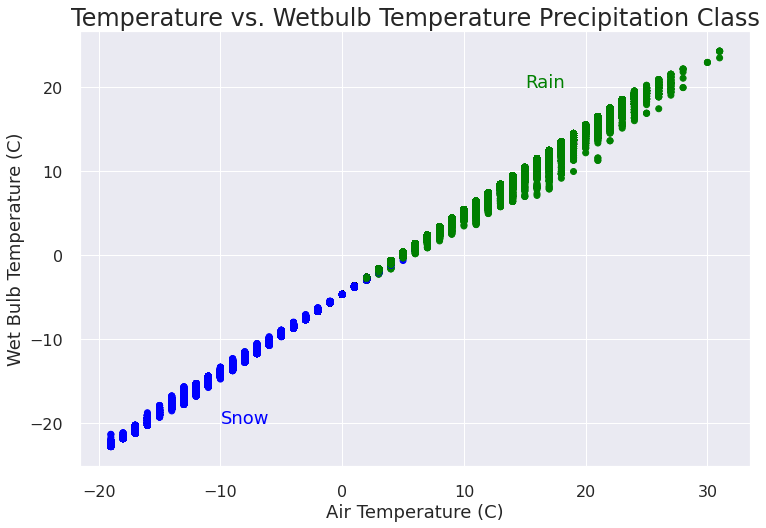

In [0]:
import matplotlib
fig = plt.figure(figsize=(12, 8))

ax = plt.axes()

label = df_rainsnow.wx1_precip_class.values

colors = ['green', 'blue']

ax.scatter(df_rainsnow.air_temperature.values, df_rainsnow.wet_bulb_temperature.values, c=label, cmap=matplotlib.colors.ListedColormap(colors))

plt.xlabel('Air Temperature (C)', fontsize=18)
plt.ylabel('Wet Bulb Temperature (C)', fontsize=18)

plt.text(-10, -20, 'Snow', c='blue', fontsize=18)
plt.text(15, 20, 'Rain', color='green', fontsize=18)

plt.title('Temperature vs. Wetbulb Temperature Precipitation Class', fontsize=24)

plt.savefig('Temperature_Wetbulb_Precip.png', dpi=300)

plt.show()

## Train and Test the Model

In [0]:
# Import Logistic Regression Module
# from sklearn.linear_model import LogisticRegression

# Intitialize the model wihout setting any hyperparameters
log_model = LogisticRegression()

# Fit the model using the training data
log_model.fit(X_train, y_train)

# Predict the new values
y_pred = log_model.predict(X_test)

# Probability of prediction for event (snow = 1)
y_prob = log_model.predict_proba(X_test.values)
y_prob_snow = y_prob[:, 1]
y_prob_snow

array([7.18841469e-10, 1.44201249e-02, 9.15847601e-01, ...,
       9.98034612e-01, 7.97592196e-09, 9.96037214e-01])

## Evaluate Model Performance Using Brier Skill Score

In [0]:
# Calculate BS_climo for calculation of Brier Skill Scores (BSSs)
y_prob_train = [sum(y_train.values) / len(y_train.values)] * len(y_train.values) # fraction of times that it snows
BS_climo = brier_score_loss(y_train.values, y_prob_train)
BS_climo

0.24267472397634532

In [0]:
# calculate brier skill score for Logisitc Regression
BS_LOG = brier_score_loss(y_test, y_prob_snow)
print('Brier score loss: ', BS_LOG)

BSS_LOG = bss_calc(BS_climo, BS_LOG)
print('Brier skill score: ', BSS_LOG)

Brier score loss:  0.022128455864060006
Brier skill score:  0.9088143359082713


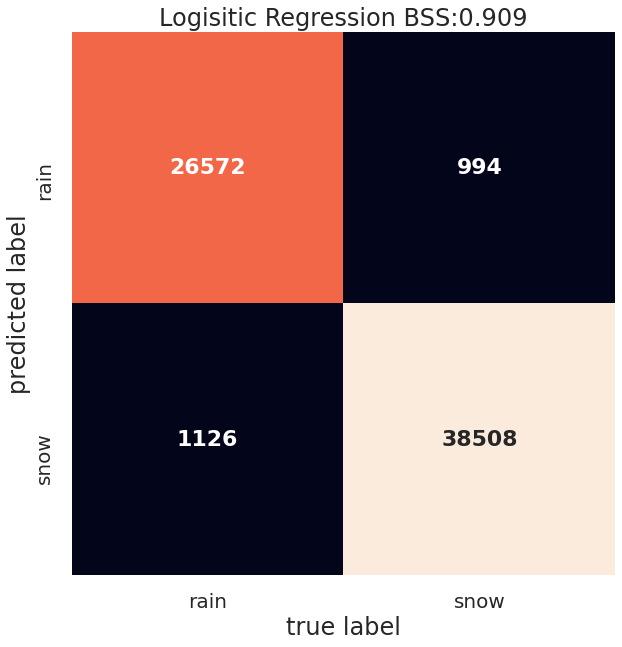

In [0]:
# plot confusion matrix
# from sklearn.metrics import confusion_matrix
# Set up formatting
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

plt.figure(figsize=(15,10))
mat = confusion_matrix(y_test, y_pred)
g = sns.heatmap(mat.T, square=True, annot=True, annot_kws={"size": 22,'weight':'bold'},fmt='d', cbar=False,
            xticklabels=['rain', 'snow'], yticklabels=['rain', 'snow'])
g.set_xticklabels(labels=['rain', 'snow'],fontsize = 20)
g.set_yticklabels(labels=['rain', 'snow'],fontsize = 20)
plt.xlabel('true label',fontsize=24)
plt.ylabel('predicted label',fontsize=24)
plt.title('Logisitic Regression BSS:{BSS}'.format(BSS=str(round(BSS_LOG,3))), fontsize=24)
#plt.savefig('Logistic_{BSS}.png'.format(BSS=str(round(BSS_LOG,3))))
plt.show()

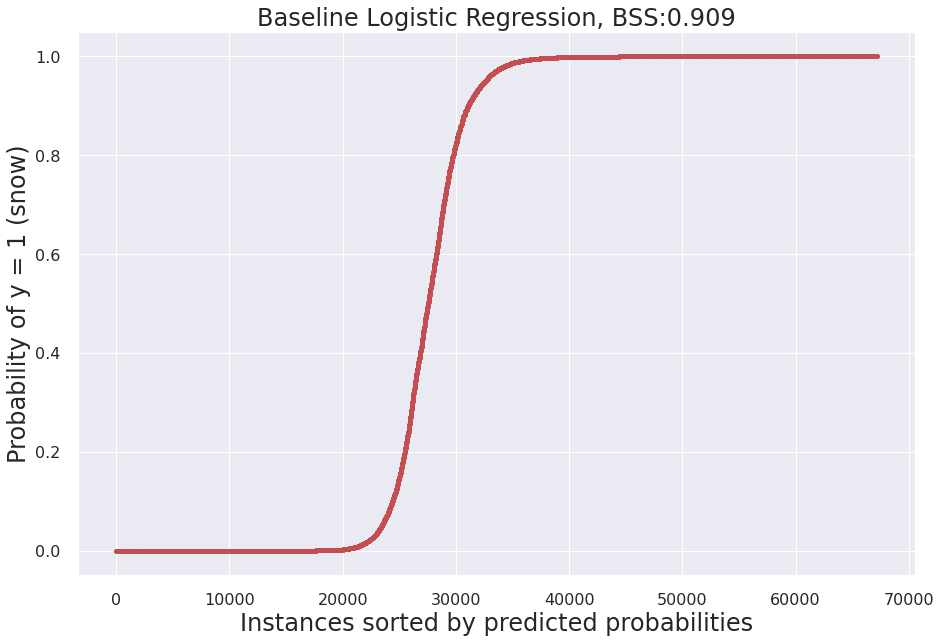

In [0]:
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

plt.figure(figsize=(15,10))
instances = np.arange(len(y_prob_snow))
plt.plot(instances, np.sort(y_prob_snow),'b--',lw=3.)
plt.plot(instances, np.sort(y_prob_snow),'r.')
plt.xlabel('Instances sorted by predicted probabilities',fontsize=24)
plt.ylabel('Probability of y = 1 (snow)',fontsize=24)
plt.title('Baseline Logistic Regression, BSS:{BSS}'.format(BSS=str(round(BSS_LOG,3))), fontsize=24)
plt.show()

# Model 2: Gaussian Naive Bayes

## Preparations

In [0]:
# A function for calculating BSS:
bss_calc = lambda bs_climo, bs_model: (bs_climo - bs_model) / bs_climo

# A function for calculating wet bulb temperature
def wet_bulb_temp(T, Td):
    """
    Calculates wet bulb temperature given formula from Omni
    """
    
    # Calculate RH
    rh = mcalc.relative_humidity_from_dewpoint(T, Td).to('percent').m
    
    # Make sure temperature is in degrees celsius
    T = T.to('degC').m
    
    # Same with dewpoint
    Td = Td.to('degC').m
    
    term1 = T * np.arctan(0.151977 * (rh + 8.313659)**(1/2))
    
    term2 = np.arctan(T + rh)
    
    term3 = np.arctan(rh - 1.676331)
    
    term4 = 0.00391838 * ((rh)**(3/2)) * np.arctan(0.023101 * rh)
    
    return term1 + term2 - term3 - 4.686035

In [0]:
# Set up and clean the DataFrame for GNB
df_rainsnow = clean_df[['wind_direction', 'wind_speed', 'air_temperature', 
                        'dew_point_temperature', 'wx1_precip_class_lag5min', 
                        'wx1_precip_class_lag10min', 'wx1_precip_class_lag15min', 
                        'wx1_precip_class']].dropna()

# calculate wet bulb temp and add to the DataFrame
df_rainsnow['wet_bulb_temperature'] = wet_bulb_temp(df_rainsnow.air_temperature.values * units.degC,
                                                    df_rainsnow.dew_point_temperature.values * units.degC)
df_rainsnow

,wind_direction,wind_speed,air_temperature,dew_point_temperature,wx1_precip_class_lag5min,wx1_precip_class_lag10min,wx1_precip_class_lag15min,wx1_precip_class,wet_bulb_temperature
date_time,,,,,,,,,
2000-01-01 00:15:00,290.0,7.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
2000-01-01 00:20:00,280.0,9.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
2000-01-01 00:25:00,280.0,10.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
2000-01-01 00:30:00,290.0,10.0,-3.0,-8.0,1.0,1.0,1.0,1.0,-7.465794
2000-01-01 00:35:00,290.0,7.0,-3.0,-7.0,1.0,1.0,1.0,1.0,-7.515322
...,...,...,...,...,...,...,...,...,...
2020-03-30 10:55:00,300.0,14.0,3.0,2.0,0.0,0.0,0.0,0.0,-1.709133
2020-03-30 11:00:00,310.0,10.0,3.0,2.0,0.0,0.0,0.0,0.0,-1.709133
2020-03-30 11:05:00,310.0,10.0,4.0,2.0,0.0,0.0,0.0,0.0,-0.776298


## Split into Training and Testing Data

In [0]:
# Spliting predictors and predictands
X = df_rainsnow[['wind_direction', 'wind_speed', 'air_temperature', 
                 'dew_point_temperature', 'wx1_precip_class_lag5min',
                 'wx1_precip_class_lag10min', #'wx1_precip_class_lag15min', 
                 'wet_bulb_temperature']]
y = df_rainsnow['wx1_precip_class']

# Spliting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Train and test

In [0]:
# Gaussian NB
model = GaussianNB()
model.fit(X_train, y_train)

# predicted y for X_test
y_pred = model.predict(X_test)

# probability of prediction for event (snow = 1)
y_prob = model.predict_proba(X_test.values)
y_prob_snow = y_prob[:, 1]
y_prob_snow

array([9.47787382e-209, 4.17805634e-197, 1.00000000e+000, ...,
       1.00000000e+000, 7.70437879e-207, 1.00000000e+000])

In [0]:
# calculate BS_climo for calculation of Brier Skill Scores (BSSs)
y_prob_train = [sum(y_train.values) / len(y_train.values)] * len(y_train.values) # fraction of times that it snows
BS_climo = brier_score_loss(y_train.values, y_prob_train)
BS_climo

0.24267472397634532

In [0]:
# calculate brier skill score for Gaussian NB
# BS_NB = brier_score_loss(y_test, y_prob_rain, pos_label=0.) # equivalant to below
BS_GNB = brier_score_loss(y_test, y_prob_snow)
print('Brier score loss: ', BS_GNB)

BSS_GNB = bss_calc(BS_climo, BS_GNB)
print('Brier skill score: ', BSS_GNB)

Brier score loss:  0.0017410714285714286
Brier skill score:  0.9928254933186155


## Calibrate and evaluate model performance

In [0]:
# Try to improve it; using example from https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html

# isotonic
clf_isotonic = CalibratedClassifierCV(model, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
BS_GNB_isotonic = brier_score_loss(y_test, prob_pos_isotonic)

# sigmoid
clf_sigmoid = CalibratedClassifierCV(model, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
BS_GNB_sigmoid = brier_score_loss(y_test, prob_pos_sigmoid)
print('Brier score losses: ', BS_GNB_isotonic, BS_GNB_sigmoid)

# caculate BSS for both mothods:
BSS_GNB_isotonic = bss_calc(BS_climo, BS_GNB_isotonic)
BSS_GNB_sigmoid = bss_calc(BS_climo, BS_GNB_sigmoid)
print('Brier skill scores: ', BSS_GNB_isotonic, BSS_GNB_sigmoid)

Brier score losses:  0.001694958508746879 0.0017373154109677456
Brier skill scores:  0.9930155127778694 0.992840970899231


In [0]:
# GNB score log:
#             After calibr.   Before calibr.
#             BS      BSS     BS      BSS
# intr.vars:  0.0217, 0.9104  0.0233, 0.9038
# +lag5min:   0.0017, 0.9930  0.0017, 0.9928 
# ++lag10min: 0.0017, 0.9930  0.0017, 0.9928
# +++lag15min:0.0022, 0.9911  0.0022, 0.9909

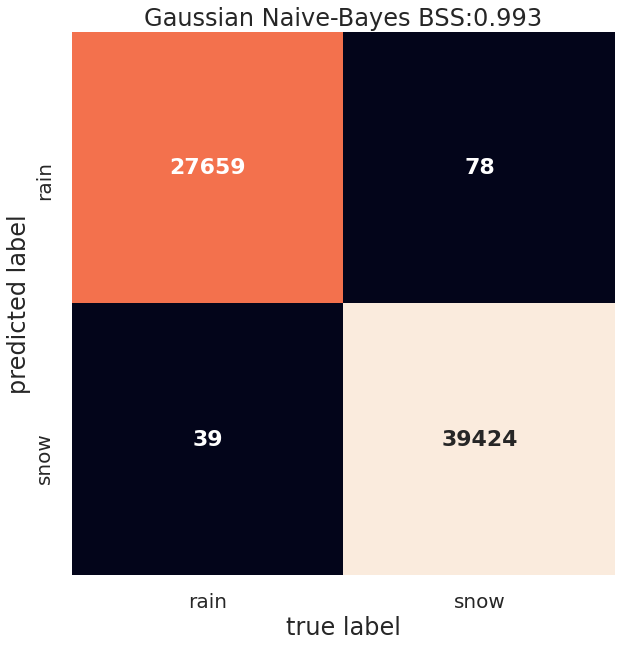

In [0]:
# use isotonically calibarted GNB to recalculate y_pred:
y_pred_isotonic = clf_isotonic.predict(X_test)

# plot confusion matrix
# from sklearn.metrics import confusion_matrix
# Set up formatting
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

plt.figure(figsize=(15,10))
mat = confusion_matrix(y_test, y_pred_isotonic)
g = sns.heatmap(mat.T, square=True, annot=True, annot_kws={"size": 22,'weight':'bold'},fmt='d', cbar=False,
            xticklabels=['rain', 'snow'], yticklabels=['rain', 'snow'])
g.set_xticklabels(labels=['rain', 'snow'],fontsize = 20)
g.set_yticklabels(labels=['rain', 'snow'],fontsize = 20)
plt.xlabel('true label',fontsize=24)
plt.ylabel('predicted label',fontsize=24)
plt.title('Gaussian Naive-Bayes BSS:{BSS}'.format(BSS=str(round(BSS_GNB_isotonic,3))), fontsize=24)
#plt.savefig('GNB_{BSS}.png'.format(BSS=str(round(BSS_GNB_isotonic,3))))
plt.show()

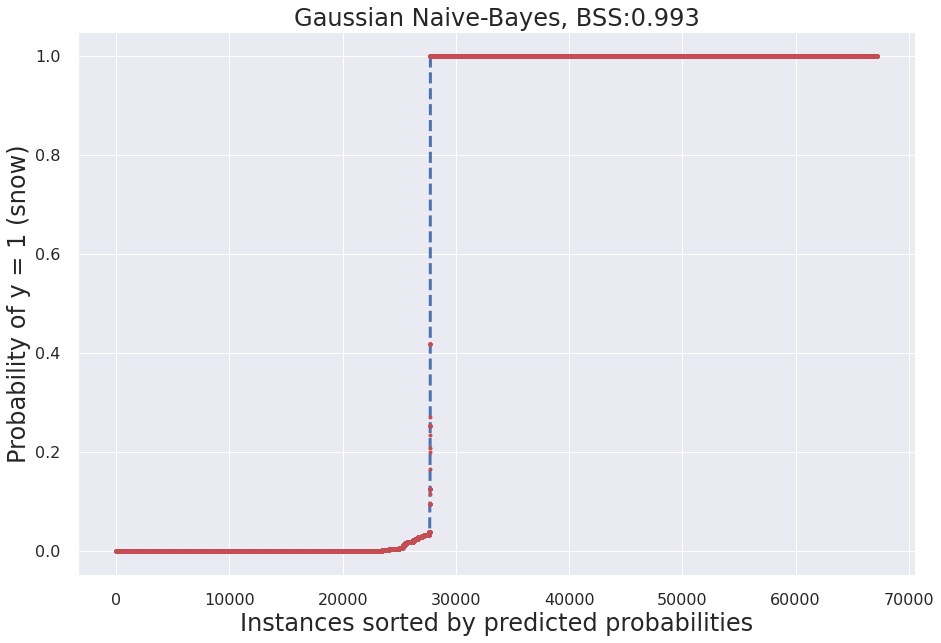

In [0]:
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

plt.figure(figsize=(15,10))
instances = np.arange(len(prob_pos_isotonic))
plt.plot(instances, np.sort(prob_pos_isotonic),'b--',lw=3.)
plt.plot(instances, np.sort(prob_pos_isotonic),'r.')
plt.xlabel('Instances sorted by predicted probabilities',fontsize=24)
plt.ylabel('Probability of y = 1 (snow)',fontsize=24)
plt.title('Gaussian Naive-Bayes, BSS:{BSS}'.format(BSS=str(round(BSS_GNB_isotonic,3))), fontsize=24)
plt.show()

# KNN Supervised Learning 

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
training_accuracy = []
test_accuracy = []
BS_KNS = []
# We define a range of 1 to 10 (included) neighbors that will be tested
neighbors_settings = range(1,25)

# We loop the KNN model through the range of possible neighbors to evaluate which one would be 
# appropriate for this analysis

for n_neighbors in neighbors_settings:
    
    # creating the KNN classifier
    clf = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1)
    # fitting the model
    clf.fit(X_train, y_train)
    #recording the accuracy of the training set
    training_accuracy.append(clf.score(X_train, y_train))
    #recording the accuracy of the test set
    test_accuracy.append(clf.score(X_test, y_test))
    
    y_prob = clf.predict_proba(X_test)
    #y_prob_rain = y_prob[:, 0]
    y_prob_snow = y_prob[:, 1]
    BS_KS = brier_score_loss(y_test, y_prob_snow,pos_label=1.)
    BS_KNS.append(BS_KS)
    print(n_neighbors)
    
    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


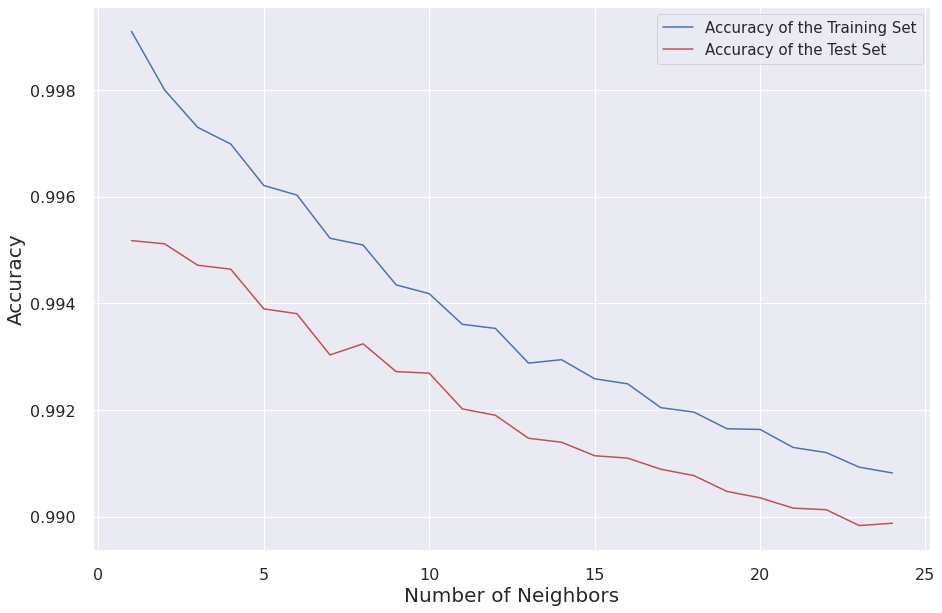

In [0]:
plt.figure(figsize=(15,10))
plt.plot(neighbors_settings, training_accuracy, 'b-',label='Accuracy of the Training Set')
plt.plot(neighbors_settings, test_accuracy, 'r-',label='Accuracy of the Test Set')
#plt.axvline(neighbors_settings[7],c='k')
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Number of Neighbors',fontsize=20)
plt.legend(loc='upper right',fontsize=15)
plt.show()

In [0]:
BSS_KNS = (BS_climo - BS_KNS) / BS_climo
BSS_KNS

array([0.98013214, 0.98230902, 0.98180823, 0.98103278, 0.98012968,
       0.97928387, 0.97846522, 0.97786902, 0.97712818, 0.97648847,
       0.97579814, 0.97510768, 0.97445617, 0.97374322, 0.97310671,
       0.97245605, 0.97172825, 0.97108243, 0.97055797, 0.96998864,
       0.96942829, 0.96881608, 0.9682123 , 0.96774059])

In [0]:
np.where(BS_KNS==np.max(BS_KNS))

(array([23]),)

In [0]:
neighbors_settings[1]

2

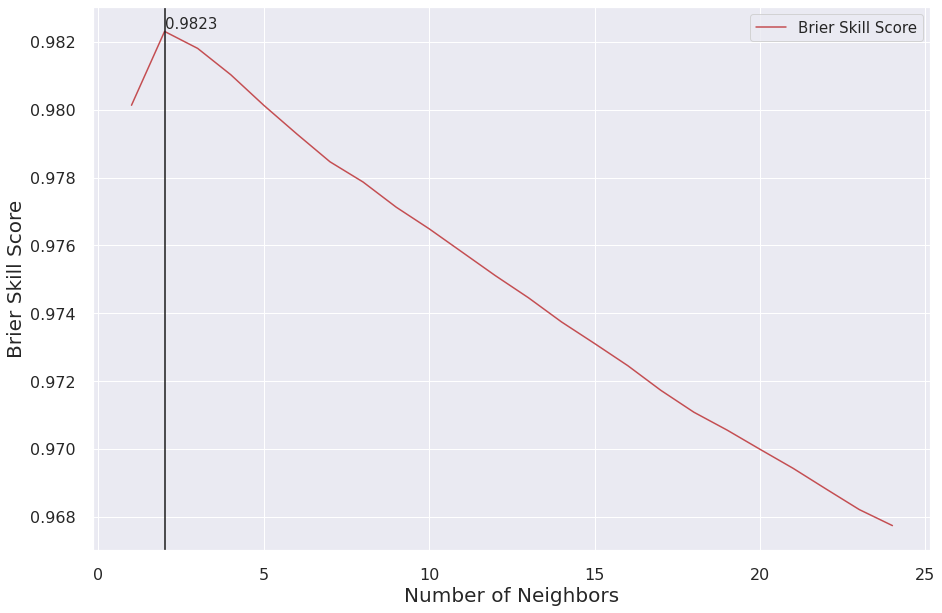

In [0]:
plt.figure(figsize=(15,10))
plt.plot(neighbors_settings, BSS_KNS, 'r-',label='Brier Skill Score')
plt.text(neighbors_settings[1],np.max(BSS_KNS)+0.0001,str(round(np.max(BSS_KNS), 4)),fontsize=15)
plt.axvline(neighbors_settings[1],c='k')
plt.ylabel('Brier Skill Score',fontsize=20)
plt.xlabel('Number of Neighbors',fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [0]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


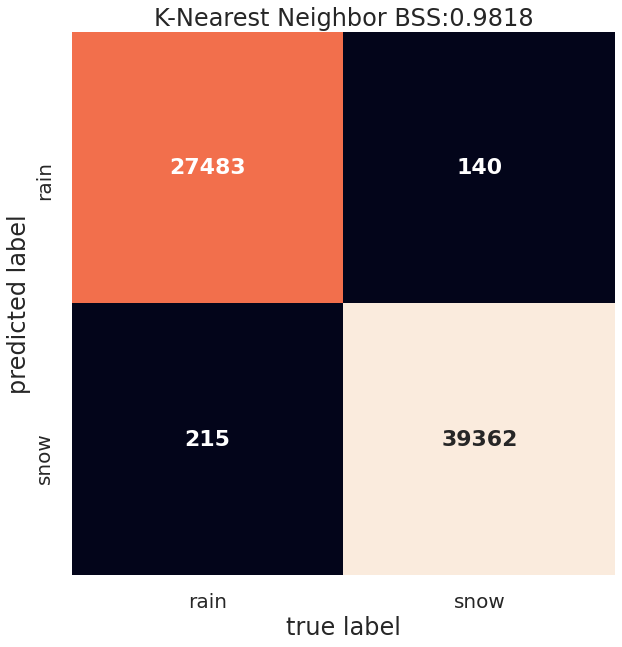

In [0]:
plt.figure(figsize=(15,10))
mat = confusion_matrix(y_test, y_pred_knn)
g = sns.heatmap(mat.T, square=True, annot=True, annot_kws={"size": 22,'weight':'bold'},fmt='d', cbar=False,
            xticklabels=['rain', 'snow'], yticklabels=['rain', 'snow'])
g.set_xticklabels(labels=['rain', 'snow'],fontsize = 20)
g.set_yticklabels(labels=['rain', 'snow'],fontsize = 20)
plt.xlabel('true label',fontsize=24)
plt.ylabel('predicted label',fontsize=24)
plt.title('K-Nearest Neighbor BSS:{BSS}'.format(BSS=str(round(BSS_KNS[2],4))), fontsize=24)
plt.show()

In [0]:
y_prob_kns = knn.predict_proba(X_test)
y_prob_snow_kns = y_prob_kns[:,1]

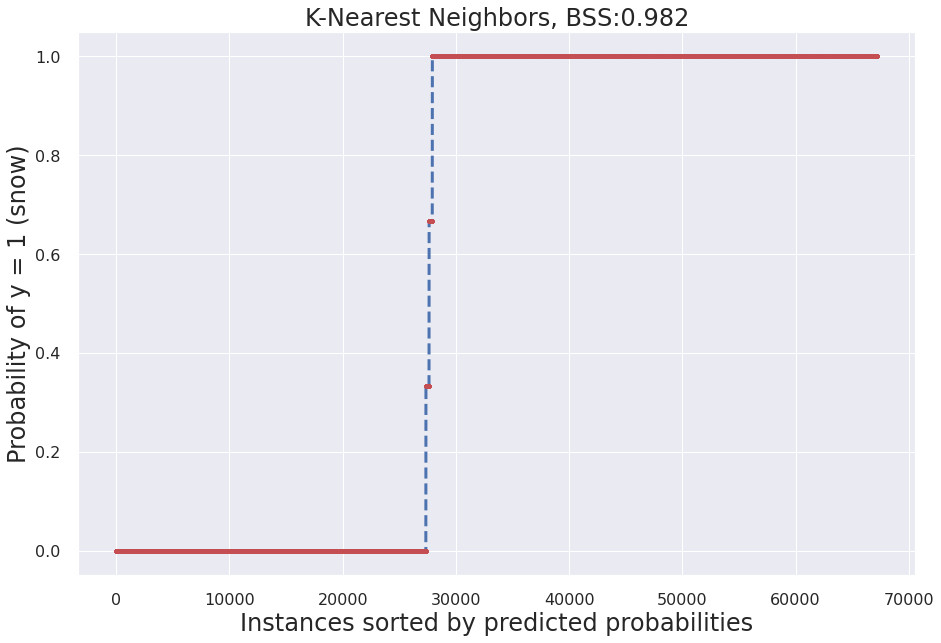

In [0]:
plt.figure(figsize=(15,10))
instances = np.arange(len(y_prob_snow_kns))
plt.plot(instances, np.sort(y_prob_snow_kns),'b--',lw=3.)
plt.plot(instances, np.sort(y_prob_snow_kns),'r.')
plt.xlabel('Instances sorted by predicted probabilities',fontsize=24)
plt.ylabel('Probability of y = 1 (snow)',fontsize=24)
plt.title('K-Nearest Neighbors, BSS:{BSS}'.format(BSS=str(round(BSS_KNS[1]+,3))), fontsize=24)
plt.show()

# SVC Supervised Learning 

In [0]:
from sklearn.svm import SVC

In [0]:
#C = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

In [0]:
#BS_SVS_c = []
#for i in range(len(C)):

svc = SVC(C=1.0,probability=True)
svc.fit(X_train,y_train)
y_prob_svc = svc.predict_proba(X_test)
y_prob_snow_svc = y_prob_svc[:, 1]
BS_SVS = brier_score_loss(y_test, y_prob_snow_svc,pos_label=1.)
#BS_SVS_c.append(BS_SVS)
#print(i)

0


In [0]:
y_pred_svc = svc.predict(X_test)


In [0]:
y_prob_rain_svc = y_prob_svc[:, 0]

(array([9.99999900e-01, 9.98730885e-01, 2.56610137e-02, ...,
        2.02981205e-08, 9.99999900e-01, 1.77428121e-07]),
 array([1.00000010e-07, 1.26911533e-03, 9.74338986e-01, ...,
        9.99999980e-01, 1.00000010e-07, 9.99999823e-01]))

In [0]:
BS_SVR = brier_score_loss(y_test, y_prob_rain_svc, pos_label=0.)
BS_SVS = brier_score_loss(y_test, y_prob_snow_svc,pos_label=1.)
BS_SVR#, brier_snow # these two are equal

0.012833093847245852

In [0]:
BSS_SVS = BSS = (BS_climo - BS_SVS) / BS_climo
BSS_SVS

0.9471181273559551

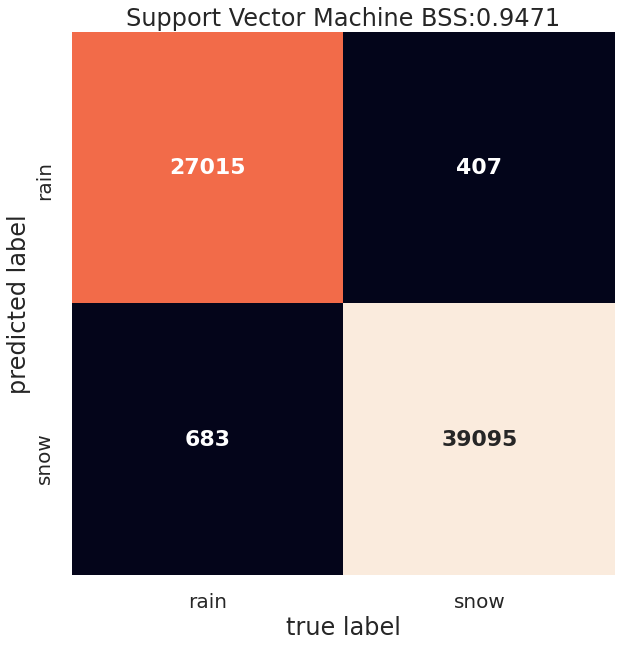

In [0]:
plt.figure(figsize=(15,10))
mat = confusion_matrix(y_test, y_pred_svc)
g = sns.heatmap(mat.T, square=True, annot=True, annot_kws={"size": 22,'weight':'bold'},fmt='d', cbar=False,
            xticklabels=['rain', 'snow'], yticklabels=['rain', 'snow'])
g.set_xticklabels(labels=['rain', 'snow'],fontsize = 20)
g.set_yticklabels(labels=['rain', 'snow'],fontsize = 20)
plt.xlabel('true label',fontsize=24)
plt.ylabel('predicted label',fontsize=24)
plt.title('Support Vector Machine BSS:{BSS}'.format(BSS=str(round(BSS_SVS,4))), fontsize=24)
plt.show()